In [85]:
%run -m ipy_startup
%run -m ipy_logging false
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling import data_broker as dbm
from ml.api import trainer as ml_trainer
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn

In [66]:
# Load data from data_modeling/prep/tcga-prep.ipynb
d = db.load_obj(src.TCGA_v1, db.PREP, 'raw-data-matrices')
d.keys()

2017-03-20 17:53:58,420:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-03-20 17:53:58,420:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"


dict_keys(['gene-methylation', 'gene-expression', 'gene-rppa', 'gene-copy-number', 'gene-exome-seq', 'gene-rna-seq'])

In [67]:
d['gene-copy-number'].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1080 entries, (brca, TCGA-3C-AAAU-01) to (brca, TCGA-Z7-A8R6-01)
Columns: 23282 entries, A1BG to ZZZ3
dtypes: float64(23282)
memory usage: 191.8+ MB


In [68]:
cohort = 'brca'

In [69]:
def prep(df, dt):
    df = df.loc[cohort]
    df.columns = pd.MultiIndex.from_tuples([(dt, c) for c in df])
    return df
df = pd.concat([prep(df, dt) for dt, df in d.items()], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, TCGA-3C-AAAU-01 to TCGA-Z7-A8R6-01
Columns: 90637 entries, (gene-methylation, A1BG) to (gene-rna-seq, ZZZ3)
dtypes: float64(90637)
memory usage: 764.1+ MB


In [70]:
df.head()

gene-methylation                                          \
                            A1BG  A1BG-AS1       A2M     A2ML1    A4GALT   
TCGA-3C-AAAU-01         0.081101  0.254970  0.939477  0.913666  0.756963   
TCGA-3C-AALI-01         0.055548  0.841712  0.783152  0.933253  0.654634   
TCGA-3C-AALJ-01         0.046994  0.728509  0.935178  0.856873  0.435268   
TCGA-3C-AALK-01         0.162858  0.762728  0.900909  0.850226  0.605654   
TCGA-4H-AAAK-01         0.183157  0.716270  0.910596  0.817014  0.556762   

                                                                    ...    \
                    A4GNT      AAAS      AACS    AACSP1     AADAC   ...     
TCGA-3C-AAAU-01  0.416099  0.029767  0.097124  0.912556  0.520440   ...     
TCGA-3C-AALI-01  0.652867  0.023413  0.504042  0.821468  0.744339   ...     
TCGA-3C-AALJ-01  0.470023  0.032650  0.118826  0.904489  0.638461   ...     
TCGA-3C-AALK-01  0.353603  0.028248  0.299652  0.908105  0.802996   ...     
TCGA-4H-AAAK-01  0.453931  0.022789  0.201803  0.950639  0.546441   ...     

                gene-rna-seq                                                  \
                      ZWILCH   ZWINT    ZXDA    ZXDB    ZXDC  ZYG11A  ZYG11B   
TCGA-3C-AAAU-01      -0.1875  0.2566  2.5022  1.4301  2.4849  1.7280  1.1117   
TCGA-3C-AALI-01       3.8487  0.3196 -0.1816 -0.4114  1.0797  1.0743 -1.0477   
TCGA-3C-AALJ-01      -0.7852  3.2911 -1.1222 -0.1302 -1.4793  2.5267 -1.3026   
TCGA-3C-AALK-01      -0.3029 -0.2431 -0.3657 -0.4472 -1.0557  0.8232 -1.0342   
TCGA-4H-AAAK-01      -0.2423 -0.2320 -0.6000 -0.4916 -0.2273 -0.9346 -0.4330   

                                         
                    ZYX   ZZEF1    ZZZ3  
TCGA-3C-AAAU-01 -0.1441  0.8941  0.3312  
TCGA-3C-AALI-01  0.9689 -0.3256 -1.1244  
TCGA-3C-AALJ-01  0.9433 -1.1210 -0.9310  
TCGA-3C-AALK-01  1.0729 -1.4634 -0.5710  
TCGA-4H-AAAK-01  0.1537 -1.3559 -0.2308  

[5 rows x 90637 columns]

In [71]:
len(df)

1105

In [96]:
# Determine the sets of gene names that are shared across TCGA, CCLE, and GDSC

def get_gene_sets(tcga_dtypes, sources, data_types):
    
    gene_sets = {}
    for data_type in tcga_dtypes:
        gene_sets[('tcga', data_type)] = df[data_type].columns.tolist()

    for source in sources:
        for data_type in data_types:
            gene_sets[(source, data_type)] = api.get_raw_genomic_data(source, data_type)['GENE_ID:HGNC'].unique()
    
    return gene_sets

gene_sets = get_gene_sets(
    [dtyp.GENE_EXPRESSION, dtyp.GENE_RNA_SEQ], 
    [src.CCLE_v1, src.GDSC_v2], 
    [dtyp.GENE_EXPRESSION]
)

In [97]:
d_gene = pd.concat([pd.Series(np.repeat(1, len(v)), index=v).rename(k) for k, v in gene_sets.items()], axis=1)
d_gene.head()

ccle_v1         tcga                         gdsc_v2
        gene-expression gene-rna-seq gene-expression gene-expression
A1BG                1.0          1.0             1.0             1.0
A1CF                1.0          1.0             NaN             1.0
A2M                 1.0          1.0             1.0             1.0
A2M-AS1             1.0          NaN             NaN             NaN
A2ML1               1.0          1.0             1.0             1.0

In [100]:
shared_genes = d_gene.dropna().index.tolist()
len(d_gene), len(d_gene.dropna())

(20482, 13415)

In [104]:
from mgds.data_modeling.constants import SEED
from sklearn.preprocessing import Imputer

# Multi-task models show virtually no signs of helping (much more the opposite)

# Next steps:
# 1. Train model on all responses and store results with performance for:
#    - ccle/gdsc GE
#    - ccle/gdsc rna-seq
#    - Mutations?

feature_typ = dtyp.GENE_RNA_SEQ
#feature_typ = dtyp.GENE_EXPRESSION
X = df[[feature_typ, dtyp.GENE_RPPA]].dropna(how='all', axis=1).dropna(how='all', axis=0)
X, Y = X[feature_typ], X[dtyp.GENE_RPPA]

# Restrict X to only those genes in the "shared" set from other sources
# (otherwise it will not be possible to make predictions using them)
X = X.filter(items=shared_genes)

mask = (X.isnull().all(axis=1)) | (Y.isnull().all(axis=1))
X = X[~mask.values].dropna(how='all', axis=1)
Y = Y[~mask.values].dropna(how='all', axis=1)

# Scale X now to make sure that predictions are more likely to work when given inputs from other sources
n_na = X.isnull().sum().sum()
print('Imputing {} X values of {}'.format(n_na, X.shape[0] * X.shape[1]))
if n_na > 0:
    X = pd.DataFrame(Imputer().fit_transform(X), index=X.index, columns=X.columns)

X = X.apply(lambda v: (v - v.mean()) / v.std())

n_na = Y.isnull().sum().sum()
print('Imputing {} Y values of {}'.format(n_na, Y.shape[0] * Y.shape[1]))
if n_na > 0:
    Y = pd.DataFrame(Imputer().fit_transform(Y), index=Y.index, columns=Y.columns)

#cols = Y.columns.tolist()
#np.random.seed(SEED)
#np.random.shuffle(cols)
#Y = Y[cols]
# start, stop = 0, 16
# Y = Y.iloc[:,start:stop]

assert X.shape[1] == len(shared_genes)
assert np.all(X.notnull())
assert np.all(Y.notnull())

Imputing 0 X values of 11268600
Imputing 2978 Y values of 144480


In [105]:
X.shape, Y.shape

((840, 13415), (840, 172))

In [106]:
Y.columns.tolist()[:25]

['ABL1',
 'ACACA',
 'ACVRL1',
 'ADAR',
 'AKT1',
 'AKT2',
 'AKT3',
 'ANXA1',
 'ANXA7',
 'AR',
 'ARAF',
 'ARID1A',
 'ASNS',
 'ATM',
 'AXL',
 'BAK1',
 'BAP1',
 'BAX',
 'BCL2',
 'BCL2A1',
 'BCL2L1',
 'BCL2L11',
 'BECN1',
 'BID',
 'BIRC2']

In [ ]:
# import imp
# imp.reload(ml_tf)

In [293]:
# Good performance for 1000 features, 10 outputs
# Also decent for 10000 features, but training takes 

# from ml.tensorflow import tflearn as ml_tf
# from ml.tensorflow import utilities as tf_utils
# from tensorflow.python.ops import logging_ops

# model_dir = '/tmp/tf/rppa_model1/'
# !rm -rf /tmp/tf/rppa_model1/*
# import pdb

# def tf_model_fn(features, targets, mode, params):
    
#     # Connect the first hidden layer to input layer
#     # (features) with relu activation
#     weight_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['weight'])
#     bias_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['bias'])
    
#     first_layer = tf.contrib.layers.linear(
#         features, len(Y.columns), 
#         weights_regularizer=weight_regularizer,
#         weights_initializer=tf.contrib.layers.init_ops.zeros_initializer,#tf.contrib.layers.initializers.variance_scaling_initializer(),
#         biases_regularizer=bias_regularizer,
#         biases_initializer=tf.contrib.layers.init_ops.zeros_initializer,
#         variables_collections=['first_layer']
#     )

#     # first_hidden_layer = tf.contrib.layers.dropout(first_hidden_layer)
#     first_layer_vars = tf.get_collection('first_layer')
#     tf.summary.histogram('first_layer', first_layer)
#     tf.summary.histogram('first_layer_w', first_layer_vars[0])
#     tf.summary.histogram('first_layer_b', first_layer_vars[1])

#     predictions = first_layer
    
#     def get_min_max(v):
#         v = pd.DataFrame(v)
#         return [v.min().min(), v.max().max()]
#     predictions_dict = {"values": predictions}
    
#     if mode == learn.ModeKeys.INFER:
#         return predictions_dict, None, None

#     mse = tf.contrib.losses.mean_squared_error(predictions, targets)
#     print('Mse: ', mse)
#     tf.summary.scalar('mse', mse)
    
#     reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     if len(reg) > 0:
#         reg = tf.add_n(reg)
#         tf.summary.scalar('reg', reg)
#         loss = mse + tf.cast(reg, tf.float32)
#     else:
#         loss = mse

#     train_op = tf.contrib.layers.optimize_loss(
#         loss=loss,
#         global_step=tf.contrib.framework.get_global_step(),
#         learning_rate=params["learning_rate"],
#         optimizer="Adam",
#         clip_gradients=1.
#     )

#     return predictions_dict, loss, train_op

# model_params = {'learning_rate': .001, 'n_hidden': [10], 'weight': 25., 'bias': 1.}

# steps = 200
# run_config = learn.RunConfig(
#     gpu_memory_fraction=.8, save_summary_steps=steps//10, 
#     save_checkpoints_steps=steps//10, save_checkpoints_secs=None,
#     keep_checkpoint_max=10
# )
# run_config.tf_config.gpu_options.allocator_type = 'BFC'
# tf_clf1 = ml_tf.LearnRegressor(
#     model_fn=tf_model_fn, 
#     model_params=model_params, 
#     fit_params={'max_steps': steps, 'batch_size': None}, 
#     model_dir = model_dir,
#     prediction_output='values',
#     model_config=run_config
# )

In [294]:
# from ml.tensorflow import tflearn as ml_tf
# from ml.tensorflow import utilities as tf_utils
# from tensorflow.python.ops import logging_ops

# model_dir = '/tmp/tf/rppa_model1/'
# !rm -rf /tmp/tf/rppa_model1/*
# import pdb

# def tf_model_fn(features, targets, mode, params):
    
#     # Connect the first hidden layer to input layer
#     # (features) with relu activation
#     weight_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['weight'])
#     bias_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['bias'])
    
#     first_layer = tf.contrib.layers.linear(
#         features, len(Y.columns), 
#         weights_regularizer=weight_regularizer,
#         weights_initializer=tf.contrib.layers.init_ops.zeros_initializer,#tf.contrib.layers.initializers.variance_scaling_initializer(),
#         biases_regularizer=bias_regularizer,
#         biases_initializer=tf.contrib.layers.init_ops.zeros_initializer,
#         variables_collections=['first_layer']
#     )

#     # first_hidden_layer = tf.contrib.layers.dropout(first_hidden_layer)
#     first_layer_vars = tf.get_collection('first_layer')
#     tf.summary.histogram('first_layer', first_layer)
#     tf.summary.histogram('first_layer_w', first_layer_vars[0])
#     tf.summary.histogram('first_layer_b', first_layer_vars[1])

#     predictions = first_layer
    
#     def get_min_max(v):
#         v = pd.DataFrame(v)
#         return [v.min().min(), v.max().max()]
#     predictions_dict = {"values": predictions}
    
#     if mode == learn.ModeKeys.INFER:
#         return predictions_dict, None, None

#     mse = tf.contrib.losses.mean_squared_error(predictions, targets)
#     print('Mse: ', mse)
#     tf.summary.scalar('mse', mse)
    
#     reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     if len(reg) > 0:
#         reg = tf.add_n(reg)
#         tf.summary.scalar('reg', reg)
#         loss = mse + tf.cast(reg, tf.float32)
#     else:
#         loss = mse

#     train_op = tf.contrib.layers.optimize_loss(
#         loss=loss,
#         global_step=tf.contrib.framework.get_global_step(),
#         learning_rate=params["learning_rate"],
#         optimizer="Adam",
#         clip_gradients=1.
#     )

#     return predictions_dict, loss, train_op

# model_params = {'learning_rate': .001, 'n_hidden': [10], 'weight': 25., 'bias': 0.}

# steps = 200
# run_config = learn.RunConfig(
#     gpu_memory_fraction=.8, save_summary_steps=steps//10, 
#     save_checkpoints_steps=steps//10, save_checkpoints_secs=None,
#     keep_checkpoint_max=10
# )
# run_config.tf_config.gpu_options.allocator_type = 'BFC'
# tf_clf1 = ml_tf.LearnRegressor(
#     model_fn=tf_model_fn, 
#     model_params=model_params, 
#     fit_params={'max_steps': steps, 'batch_size': None}, 
#     model_dir = model_dir,
#     prediction_output='values',
#     model_config=run_config
# )

In [295]:
# model_dir = '/tmp/tf/rppa_model2/'
# !rm -rf /tmp/tf/rppa_model2/*

# def monitor_fn(X, y): 
#     return {'loss': learn.monitors.CaptureVariable('global_step')}

# tf_clf2 = ml_tf.LearnRegressor(
#     model_fn=lambda model_dir: learn.DNNRegressor(
#         hidden_units=[10], 
#         #dropout=.5,
#         feature_columns=learn.infer_real_valued_columns_from_input(X), 
#         optimizer=tf.train.GradientDescentOptimizer(.001),
#         model_dir=model_dir,
#         label_dimension=Y.shape[1],
#         config=learn.RunConfig(
#             gpu_memory_fraction=.5, save_summary_steps=30, 
#             save_checkpoints_steps=30, save_checkpoints_secs=None,
#             keep_checkpoint_max=10
#         )
#     ),
#     model_dir=model_dir,
#     fit_params={'max_steps': 300, 'monitor_fn': monitor_fn},
# )

In [109]:
#%%time
from ml.sklearn import feature_selection as ml_feature_selection
from sklearn.linear_model import MultiTaskLasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import MultiTaskLassoCV, LassoCV, MultiTaskElasticNetCV
from sklearn.svm import SVR


# imputer_mean = lambda X: Imputer(strategy='mean').fit_transform(X)
# imputer_mice = lambda X: MICE(verbose=False).complete(np.array(X))
# imputer_knn = lambda X: KNN(verbose=False, normalizer=BiScaler(verbose=False, center_rows=False, scale_rows=False)).complete(np.array(X))
# imputer_nnorm = lambda X: NuclearNormMinimization(verbose=False).complete(np.array(X))

def pipeline(estimator, nzv=True, scale=False, select=True, impute=True):
    steps = []        
#     if impute:
#         steps.append(('impute', Imputer(strategy='mean')))
    if nzv:
        steps.append(('nzv', VarianceThreshold()))
    if scale:
        steps.append(('scale', StandardScaler()))
    if select:
        selector = SelectKBest(f_regression, k=300)
        steps.append(('select', ml_feature_selection.MultiOutputSelect(selector=selector, strategy='any')))
        #steps.append(('select', selector))
    steps.append(('clf', estimator))
    return Pipeline(steps)

def get_train_res(X, Y):
    # Single-task only
#     assert Y.ndim == 1
#     clfs = {
#         'lasso': pipeline(LassoCV(random_state=SEED, n_alphas=25, max_iter=2500)),
#         'svr': pipeline(GridSearchCV(SVR(), {'C': [.1, 1, 5, 10, 15, 50, 100]}, cv=3)),
#         'baseline': pipeline(DummyRegressor())
#     }

#     clfs = {
#         #'st_etr': pipeline(ExtraTreesRegressor(random_state=SEED)),
#         #'mt_etr': pipeline(MultiOutputRegressor(ExtraTreesRegressor(random_state=SEED))),
#         #'st_mlp': pipeline(MultiOutputRegressor(GridSearchCV(MLPRegressor(random_state=SEED), {'hidden_layer_sizes': [(20, 50)], 'alpha': [.001, .01, .1, .5]}, cv=3))),
#         'st_lasso': pipeline(MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25, max_iter=2500))),
#         #'mt_lasso': pipeline(MultiTaskLassoCV(random_state=SEED, n_alphas=25, max_iter=2500)),
#         #'mt_enet': pipeline(MultiTaskElasticNetCV(random_state=SEED, n_alphas=25, max_iter=2500)),
#         'st_svr': pipeline(MultiOutputRegressor(GridSearchCV(SVR(), {'C': [.1, 1, 5, 10, 15, 50, 100]}, cv=3))),
#         'st_baseline': pipeline(MultiOutputRegressor(DummyRegressor()))
#     }
    clfs = {
        'lasso': pipeline(MultiTaskLassoCV(random_state=SEED, n_alphas=10, max_iter=5000, n_jobs=3)),
        'baseline': pipeline(MultiOutputRegressor(DummyRegressor()))
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # def data_prep_fn(X_train, X_test, Y_train, Y_test):
    #     Y_train = pd.DataFrame(imputer_mice(Y_train), columns=Y_train.columns, index=Y_train.index)
    #     return X_train, X_test, Y_train, Y_test

    def model_fit_fn(clf_name, clf, X_train, Y_train, X_test, Y_test, fold):
        clf.fit(X_train.values, Y_train.values)

    config = ml_trainer.TrainerConfig(
    #     data_prep_fn=data_prep_fn,
        model_fit_fn=model_fit_fn,
        keep_test_data=True
    )

    # tf.logging.set_verbosity(tf.logging.ERROR)
    trainer = ml_trainer.Trainer()
    train_res = trainer.train_regressors(X, Y, clfs, cv.split(X), config=config)
    return train_res

## Multi-Task Modeling

In [ ]:
train_res = get_train_res(X, Y)

2017-03-20 19:25:50,393:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 13415), dim(X_test) = (168, 13415), dim(Y_train) = (672, 172), dim(Y_test) = (168, 172)
2017-03-20 19:25:50,393:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 13415), dim(X_test) = (168, 13415), dim(Y_train) = (672, 172), dim(Y_test) = (168, 172)
2017-03-20 19:25:50,393:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 13415), dim(X_test) = (168, 13415), dim(Y_train) = (672, 172), dim(Y_test) = (168, 172)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 19:26:01,996:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 13415), dim(X_test) = (168, 13415), dim(Y_train) = (672, 172), dim(Y_test) = (168, 172)
2017-03-20 19:26:01,996:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 13415), dim(X_test) = (168, 13415), dim(Y_train) = (672, 172), dim(Y_test) = (168, 172)
2017-03-20 19:26:01,996:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 13415), dim(X_test) = (168, 13415), dim(Y_train) = (672, 172), dim(Y_test) = (168, 172)


In [ ]:
path = dbm.file('rppa', 'cohorts/brca/rna_seq/multi_task/train_res')
train_res.save(path)

## Single-Task Modeling

In [ ]:
# Single-task modeling
for drug_name in Y:
    y = Y[drug_name]
    mask = y.notnull()
    print('Training for drug {} [X = {}, Y = {}]'.format(drug_name, X[mask].shape, y[mask].shape))
    train_res = get_train_res(X[mask], y[mask])
    #path = dbm.file('rppa', 'cohorts/brca/gene_expression/{}'.format(drug_name))
    path = dbm.file('rppa', 'cohorts/brca/rna_seq/single_task/{}'.format(drug_name))
    train_res.save(path)

2017-03-19 08:26:08,196:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug ABL1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:26:08,660:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:26:12,456:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:26:15,861:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:26:16,147:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:26:45,927:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:26:50,050:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:26:55,267:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:26:55,268:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:26:55,269:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ACACA [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:26:57,453:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:26:59,798:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:27:03,087:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:27:03,403:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:27:26,601:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:27:28,629:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:27:33,812:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:27:33,813:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:27:33,874:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ACVRL1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:27:36,091:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:27:39,546:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:27:42,914:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:27:43,186:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:28:11,725:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:28:15,317:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:28:20,564:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:28:20,565:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:28:20,625:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ADAR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:28:22,816:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:28:25,699:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:28:29,084:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:28:29,360:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:28:55,627:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:28:58,734:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:29:03,975:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:29:03,976:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:29:04,039:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug AKT1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:29:06,255:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:29:08,852:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:29:12,212:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:29:12,487:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:29:38,672:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:29:41,759:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:29:47,036:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:29:47,037:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:29:47,100:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug AKT2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:29:49,353:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:29:51,971:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:29:55,280:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:29:55,560:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:30:21,797:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:30:24,871:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:30:30,130:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:30:30,131:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:30:30,193:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug AKT3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:30:32,411:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:30:34,977:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:30:38,288:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:30:38,563:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:31:04,775:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:31:07,864:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:31:13,008:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:31:13,009:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:31:13,073:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ANXA1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:31:15,283:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:31:18,145:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:31:21,432:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:31:21,714:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:31:47,434:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:31:50,387:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:31:55,507:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:31:55,508:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:31:55,576:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ANXA7 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:31:57,794:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:32:00,986:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:32:04,346:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:32:04,626:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:32:32,268:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:32:35,472:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:32:40,700:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:32:40,701:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:32:40,766:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug AR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:32:43,060:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:32:45,630:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:32:48,986:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:32:49,277:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:33:14,101:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:33:16,738:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:33:21,926:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:33:21,927:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:33:21,986:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ARAF [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:33:24,219:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:33:26,803:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:33:30,135:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:33:30,410:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alp

Beginning model refitting


2017-03-19 08:33:58,018:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:34:01,055:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:34:06,258:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:34:06,259:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:34:06,319:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ARID1A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:34:08,583:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:34:11,913:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:34:15,248:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:34:15,530:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:34:42,928:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:34:46,208:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:34:51,412:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:34:51,413:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:34:51,478:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ASNS [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:34:53,696:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:34:56,192:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:34:59,455:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:34:59,743:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:35:23,722:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:35:26,296:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:35:31,350:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:35:31,351:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:35:31,413:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ATM [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:35:33,600:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:35:36,771:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:35:40,171:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:35:40,459:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:36:08,419:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:36:11,890:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:36:17,270:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:36:17,270:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:36:17,332:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug AXL [X = (707, 18959), Y = (707,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:36:19,451:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:36:22,321:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-19 08:36:24,744:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-19 08:36:24,957:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:36:47,645:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:36:50,691:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
2017-03-19 08:36:54,509:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:36:54,510:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:36:54,566:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BAK1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:36:56,676:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:37:00,517:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:37:03,895:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:37:04,180:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:37:33,908:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:37:37,788:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:37:43,080:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:37:43,081:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:37:43,138:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BAP1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:37:45,322:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:37:48,428:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:37:51,675:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:37:51,969:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:38:18,757:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:38:22,087:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:38:27,097:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:38:27,098:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:38:27,155:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BAX [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:38:29,354:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:38:32,867:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:38:36,220:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:38:36,503:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:39:05,379:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:39:09,114:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:39:14,352:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:39:14,353:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:39:14,415:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BCL2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:39:16,639:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:39:18,765:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:39:22,024:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:39:22,317:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:39:45,631:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:39:47,832:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:39:52,904:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:39:52,905:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:39:52,968:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BCL2A1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:39:55,156:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:39:58,464:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:40:01,798:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:40:02,082:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:40:30,125:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:40:33,638:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:40:38,812:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:40:38,813:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:40:38,874:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BCL2L1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:40:41,111:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:40:44,520:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:40:47,881:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:40:48,166:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:41:15,181:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:41:18,563:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:41:23,796:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:41:23,797:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:41:23,858:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BCL2L11 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:41:26,074:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:41:29,055:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:41:32,336:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:41:32,619:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:41:59,182:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:42:02,071:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:42:07,185:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:42:07,186:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:42:07,248:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BECN1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:42:09,399:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:42:12,297:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:42:15,588:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:42:15,869:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:42:41,568:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:42:44,902:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:42:49,977:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:42:49,977:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:42:50,041:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BID [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:42:52,185:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:42:55,899:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:42:59,233:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:42:59,524:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:43:28,430:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:43:32,316:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:43:37,489:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:43:37,490:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:43:37,554:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BIRC2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:43:39,782:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:43:43,446:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:43:46,811:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:43:47,108:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:44:15,669:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:44:19,314:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:44:24,477:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:44:24,478:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:44:24,537:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BRAF [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:44:26,891:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:44:30,009:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:44:33,302:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:44:33,596:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:45:01,094:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:45:04,420:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:45:09,610:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:45:09,611:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:45:09,673:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BRCA2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:45:11,889:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:45:15,547:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:45:18,897:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:45:19,182:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:45:47,715:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:45:50,930:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:45:56,079:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:45:56,080:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:45:56,142:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug BRD4 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:45:58,532:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:46:01,923:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:46:05,207:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:46:05,493:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:46:33,214:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:46:36,731:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:46:41,829:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:46:41,830:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:46:41,890:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CASP3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:46:44,130:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:46:47,562:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:46:50,801:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:46:51,142:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:47:20,557:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:47:21,276:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:47:25,275:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:47:30,392:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:47:30,393:INFO:ml.model.log: ---------------------------

Training for drug CASP7 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:47:32,766:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:47:35,118:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:47:38,488:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:47:38,784:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:48:02,774:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:48:05,199:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:48:10,436:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:48:10,437:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:48:10,507:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CASP8 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:48:12,797:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:48:16,261:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:48:19,552:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:48:19,823:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:48:47,149:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:48:50,713:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:48:55,728:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:48:55,728:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:48:55,787:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CASP9 [X = (74, 18959), Y = (74,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:48:57,763:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (59, 18959), dim(X_test) = (15, 18959), dim(Y_train) = (59,), dim(Y_test) = (15,)
2017-03-19 08:48:57,798:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (59, 18959), dim(X_test) = (15, 18959), dim(Y_train) = (59,), dim(Y_test) = (15,)
2017-03-19 08:48:57,921:INFO:ml.model.log: Running model svr (Pipeline) on fold 2 ==> dim(X_train) = (59, 18959), dim(X_test) = (15, 18959), dim(Y_train) = (59,), dim(Y_test) = (15,)
2017-03-19 08:48:58,014:INFO:ml.model.log: Running model baseline (Pipeline) on fold 3 ==> dim(X_train) = (59, 18959), dim(X_test) = (15, 18959), dim(Y_train) = (59,), dim(Y_test) = (15,)
2017-03-19 08:48:58,049:INFO:ml.model.log: Running model lasso (Pipeline) on fold 3 ==> dim(X_train) = (59, 18959), dim(X_test) = (15, 18959), dim(Y_train) = (59,), dim(Y_test) = (15,)
2017-03-19 08:48:58,193:INFO:ml.model.log: Running model svr (Pipeline)

Beginning model refitting


2017-03-19 08:48:59,178:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (74, 18959), dim(X_test) = (74, 18959), dim(Y_train) = (74,), dim(Y_test) = (74,)
2017-03-19 08:48:59,290:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:48:59,291:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:48:59,336:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/CASP9.pkl"
2017-03-19 08:49:00,499:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug CAV1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:49:00,812:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:49:03,599:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:49:06,989:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:49:07,285:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:49:33,254:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:49:36,244:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:49:41,350:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:49:41,351:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:49:41,381:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CCNB1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:49:43,674:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:49:46,043:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:49:49,380:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:49:49,681:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:50:13,957:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:50:16,489:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:50:21,615:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:50:21,616:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:50:21,680:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CCND1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:50:24,257:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:50:27,361:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:50:30,725:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:50:31,014:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:50:58,756:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:51:02,122:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:51:07,180:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:51:07,180:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:51:07,239:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CCNE1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:51:09,371:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:51:12,155:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:51:15,200:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:51:15,467:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:51:39,281:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:51:42,100:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:51:46,853:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:51:46,854:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:51:46,918:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CCNE2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:51:49,016:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:51:51,905:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:51:55,086:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:51:55,356:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:52:21,269:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:52:24,358:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:52:29,509:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:52:29,510:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:52:29,571:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDH1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:52:31,968:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:52:34,873:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:52:38,217:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:52:38,514:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:53:05,069:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:53:08,135:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:53:13,362:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:53:13,363:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:53:13,427:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDH2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:53:15,644:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:53:19,040:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:53:22,435:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:53:22,688:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:53:50,119:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:53:53,629:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:53:58,719:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:53:58,720:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:53:58,777:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDH3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:54:00,906:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:54:03,997:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:54:07,243:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:54:07,518:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:54:34,282:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:54:37,620:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:54:42,611:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:54:42,612:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:54:42,670:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDK1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:54:44,899:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:54:48,425:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:54:51,697:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:54:52,017:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:55:20,457:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:55:23,978:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:55:29,282:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:55:29,284:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:55:29,356:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDKN1A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:55:31,784:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:55:35,384:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:55:38,764:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:55:39,095:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:56:07,672:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:56:11,308:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:56:16,363:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:56:16,364:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:56:16,422:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDKN1B [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:56:18,503:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:56:21,237:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:56:24,417:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:56:24,672:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:56:49,436:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:56:52,329:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:56:57,284:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:56:57,285:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:56:57,347:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CDKN2A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:56:59,519:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:57:02,552:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:57:05,805:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:57:06,071:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:57:33,795:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:57:37,027:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:57:42,382:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:57:42,383:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:57:42,448:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CHEK1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:57:44,755:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:57:48,383:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:57:51,737:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:57:52,019:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:58:20,887:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:58:24,527:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:58:29,527:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:58:29,528:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:58:29,587:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CHEK2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:58:31,707:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:58:34,418:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:58:37,610:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:58:37,880:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:59:02,893:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:59:05,745:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:59:10,711:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:59:10,712:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:59:10,769:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CLDN7 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:59:12,856:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:59:15,909:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:59:19,025:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 08:59:19,279:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 08:59:45,947:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 08:59:49,246:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 08:59:54,320:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 08:59:54,320:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 08:59:54,382:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug COG3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 08:59:56,740:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:00:00,290:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:00:03,618:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:00:03,900:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 09:00:32,181:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:00:35,491:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 09:00:40,664:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 09:00:40,665:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 09:00:40,730:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug COL6A1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 09:00:43,015:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:00:46,356:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:00:49,708:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:00:49,976:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 09:01:16,869:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:01:20,071:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 09:01:25,053:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 09:01:25,054:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 09:01:25,113:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug COPS5 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 09:01:27,509:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:01:30,985:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:01:34,198:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:01:34,474:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 09:02:02,606:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:02:06,574:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 09:02:11,924:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 09:02:11,925:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 09:02:11,990:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug CTNNA1 [X = (133, 18959), Y = (133,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 09:02:14,305:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-19 09:02:14,464:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-19 09:02:14,517:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:02:15,237:INFO:ml.model.log: Running model svr (Pipeline) on fold 2 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106

Beginning model refitting


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:02:18,922:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (133, 18959), dim(X_test) = (133, 18959), dim(Y_train) = (133,), dim(Y_test) = (133,)
2017-03-19 09:02:19,146:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 09:02:19,147:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 09:02:19,186:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/CTNNA1.pkl"
2017-03-19 09:02:20,419:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959

Training for drug CTNNB1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 09:02:20,700:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 09:39:45,010:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:39:48,506:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 09:39:48,820:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-19 10:40:16,844:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 10:40:20,151:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 10:40:25,475:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 10:40:25,476:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-19 10:40:25,523:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug DIABLO [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)

2017-03-19 10:40:31,033:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 10:40:32,032:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 10:40:43,555:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 10:40:57,414:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_t


Beginning model refitting


2017-03-19 11:42:13,432:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 11:42:14,992:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 11:42:26,779:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 11:42:48,475:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 11:42:48,478:INFO:ml.model.log: ---------------------------

Training for drug DIRAS3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-19 11:42:54,554:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 11:42:55,389:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 12:43:06,532:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-19 12:43:09,779:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_t

Beginning model refitting


2017-03-19 13:19:20,850:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 13:19:22,362:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-19 13:19:36,400:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-19 16:19:49,514:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-19 16:19:49,515:INFO:ml.model.log: ---------------------------

Training for drug DPP4 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:31:11,219:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:31:11,777:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:31:15,505:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:31:18,934:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_t

Beginning model refitting


2017-03-20 06:31:47,341:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:31:50,839:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:31:55,866:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:31:55,867:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:31:55,916:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug DVL3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:31:57,966:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:32:01,153:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:32:04,369:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:32:04,615:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:32:30,468:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:32:33,708:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:32:38,862:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:32:38,863:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:32:38,907:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EEF2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:32:41,100:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:32:44,578:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:32:47,838:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:32:48,095:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:33:15,668:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:33:19,141:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:33:24,132:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:33:24,133:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:33:24,180:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EEF2K [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:33:26,231:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:33:29,307:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:33:32,445:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:33:32,694:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:33:58,408:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:34:01,368:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:34:06,277:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:34:06,278:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:34:06,325:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EGFR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:34:08,400:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:34:10,437:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:34:13,822:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:34:14,164:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:34:37,721:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:34:39,853:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:34:44,998:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:34:44,999:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:34:45,053:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EIF4E [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:34:47,316:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:34:49,070:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:34:52,397:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:34:52,673:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alp

Beginning model refitting


2017-03-20 06:35:14,284:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:35:15,946:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:35:21,150:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:35:21,151:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:35:21,200:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EIF4EBP1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:35:23,384:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:35:25,686:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:35:28,918:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:35:29,194:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:35:52,351:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:35:54,681:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:35:59,641:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:35:59,642:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:35:59,691:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EIF4G1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:36:01,774:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:36:04,827:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:36:07,996:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:36:08,254:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:36:35,029:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:36:38,258:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:36:43,197:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:36:43,198:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:36:43,252:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ENY2 [X = (707, 18959), Y = (707,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:36:45,284:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:36:48,300:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 06:36:50,608:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 06:36:50,797:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:37:13,132:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:37:16,272:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
2017-03-20 06:37:20,074:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:37:20,074:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:37:20,132:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug EPPK1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:37:22,223:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:37:24,725:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:37:28,064:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:37:28,401:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:37:52,420:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:37:55,096:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:38:00,329:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:38:00,330:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:38:00,387:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ERBB2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:38:02,743:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:03,749:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:06,976:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:07,263:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:08,249:INFO:ml.model.log: Running model svr (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:11,463:INFO:ml.model.log: Running model

Beginning model refitting


2017-03-20 06:38:24,689:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:38:25,561:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:38:30,487:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:38:30,487:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:38:30,544:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/ERBB2.pkl"
2017-03-20 06:38:32,475:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug ERBB3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:38:32,748:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:38:35,793:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:39,040:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:38:39,298:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:39:05,977:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:39:09,057:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:39:14,220:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:39:14,221:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:39:14,280:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ERCC1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:39:16,414:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:39:19,282:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:39:22,367:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:39:22,635:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:39:47,294:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:39:50,557:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:39:55,500:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:39:55,500:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:39:55,558:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ERCC5 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:39:58,993:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:40:02,500:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:40:05,770:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:40:06,053:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:40:35,107:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:40:39,216:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:40:46,110:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:40:46,111:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:40:46,188:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ERRFI1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:40:48,758:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:40:52,943:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:40:56,479:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:40:56,758:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:41:25,506:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:41:29,081:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:41:34,285:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:41:34,286:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:41:34,349:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ESR1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:41:36,857:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:41:39,209:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:41:42,404:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:41:42,681:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:42:06,195:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:42:08,520:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:42:13,419:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:42:13,420:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:42:13,479:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ETS1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:42:15,939:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:42:19,144:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:42:22,462:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:42:22,750:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:42:51,879:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:42:55,800:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:43:01,112:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:43:01,113:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:43:01,178:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug FASN [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:43:03,844:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:43:06,438:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:43:09,764:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:43:10,066:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:43:34,017:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:43:36,083:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:43:41,083:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:43:41,084:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:43:41,144:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug FN1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:43:43,614:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:43:46,819:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:43:50,151:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:43:50,406:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:44:17,941:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:44:21,859:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:44:27,369:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:44:27,370:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:44:27,453:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug FOXM1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:44:30,390:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:44:33,549:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:44:37,083:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:44:37,382:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:45:03,066:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:45:05,871:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:45:11,209:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:45:11,210:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:45:11,276:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug FOXO3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:45:13,972:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:45:16,547:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:45:20,021:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:45:20,316:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:45:47,626:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:45:50,590:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:45:55,593:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:45:55,594:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:45:55,652:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug G6PD [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:45:57,999:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:45:59,648:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:02,778:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:03,033:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:46:23,145:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:46:24,575:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:46:29,786:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:46:29,787:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:46:29,849:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug GAB2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:46:32,495:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:33,491:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:36,881:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:37,153:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:37,969:INFO:ml.model.log: Running model svr (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:46:41,342:INFO:ml.model.log: Running model

Beginning model refitting


2017-03-20 06:46:55,522:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:46:56,431:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:47:01,722:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:47:01,723:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:47:01,786:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/GAB2.pkl"
2017-03-20 06:47:03,966:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug GAPDH [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:47:04,245:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:47:07,259:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:47:10,643:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:47:10,909:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:47:38,223:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:47:41,509:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:47:46,880:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:47:46,881:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:47:46,951:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug GATA3 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:47:49,268:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:47:51,521:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:47:54,902:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:47:55,199:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:48:18,160:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:48:20,397:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:48:25,288:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:48:25,288:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:48:25,347:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug GATA6 [X = (707, 18959), Y = (707,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:48:27,373:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:48:30,642:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 06:48:32,905:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 06:48:33,096:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:48:55,421:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:48:58,749:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
2017-03-20 06:49:02,380:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:49:02,381:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:49:02,435:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug GSK3A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:49:04,507:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:49:08,188:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:49:11,412:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:49:11,681:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:49:38,676:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:49:42,150:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:49:47,339:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:49:47,340:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:49:47,398:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug GSK3B [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:49:49,569:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:49:53,295:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:49:56,503:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:49:56,765:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:50:23,926:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:50:27,435:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:50:32,396:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:50:32,397:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:50:32,454:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug HSPA1A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:50:34,571:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:50:37,996:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:50:41,201:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:50:41,459:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:51:09,447:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:51:13,183:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:51:18,227:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:51:18,228:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:51:18,285:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug IGFBP2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:51:20,402:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:51:23,116:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:51:26,341:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:51:26,600:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:51:52,034:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:51:55,106:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:52:00,008:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:52:00,009:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:52:00,067:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug INPP4B [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:52:02,183:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:52:04,482:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:52:07,661:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:52:07,928:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:52:31,407:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:52:33,844:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:52:38,806:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:52:38,807:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:52:38,864:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug IRF1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:52:40,938:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:52:44,320:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:52:47,550:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:52:47,812:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:53:15,542:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:53:19,171:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:53:24,252:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:53:24,253:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:53:24,313:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug IRS1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:53:26,452:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:53:29,131:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:53:32,296:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:53:32,553:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:53:56,627:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:53:59,296:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:54:04,245:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:54:04,246:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:54:04,308:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug ITGA2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:54:06,433:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:54:09,179:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:54:12,476:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:54:12,736:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:54:38,361:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:54:41,440:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:54:46,943:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:54:46,944:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:54:47,006:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug JAK2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:54:49,260:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:54:52,762:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:54:56,116:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:54:56,399:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:55:24,531:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:55:28,022:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:55:33,228:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:55:33,228:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:55:33,292:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug KAT2A [X = (707, 18959), Y = (707,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:55:35,487:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:55:38,666:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 06:55:41,134:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 06:55:41,357:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:56:05,115:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:56:08,878:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
2017-03-20 06:56:12,792:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:56:12,793:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:56:12,859:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug KDR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:56:15,175:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:56:18,152:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:56:21,812:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:56:22,175:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:56:48,731:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:56:51,397:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:56:56,489:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:56:56,490:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:56:56,548:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug KIT [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:56:58,772:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:57:01,221:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:57:04,508:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:57:04,802:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:57:29,782:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:57:32,587:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:57:37,702:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:57:37,703:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:57:37,772:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug LCK [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:57:39,967:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:57:42,430:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:57:45,804:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:57:46,092:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:58:11,443:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:58:14,120:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:58:19,397:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:58:19,398:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:58:19,465:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MAP2K1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:58:21,730:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:58:25,097:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:58:28,414:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:58:28,702:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:58:56,229:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:58:59,647:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:59:04,784:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:59:04,784:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:59:04,852:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MAPK1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:59:07,049:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:59:10,534:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:59:13,844:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 06:59:14,125:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 06:59:42,576:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:59:46,339:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 06:59:51,570:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 06:59:51,571:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 06:59:51,632:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MAPK14 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 06:59:53,861:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 06:59:57,114:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:00:00,418:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:00:00,712:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:00:27,977:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:00:31,064:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:00:36,222:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:00:36,223:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:00:36,291:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MAPK9 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:00:38,517:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:00:41,182:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:00:44,450:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:00:44,744:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:01:10,982:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:01:13,885:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:01:19,027:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:01:19,028:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:01:19,096:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MET [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:01:21,338:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:01:24,680:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:01:27,772:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:01:28,057:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:01:55,510:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:01:59,153:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:02:03,954:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:02:03,955:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:02:04,025:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MRE11A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:02:06,245:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:02:09,777:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:02:13,110:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:02:13,401:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:02:41,289:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:02:41,853:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:02:45,525:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:02:50,700:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:02:50,701:INFO:ml.model.log: ---------------------------

Training for drug MS4A1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:02:53,002:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:02:56,218:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:02:59,506:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:02:59,794:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:03:28,033:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:03:31,706:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:03:36,864:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:03:36,865:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:03:36,930:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MSH2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:03:39,309:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:03:42,877:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:03:46,625:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:03:46,970:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:04:14,975:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:04:18,211:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:04:23,534:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:04:23,535:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:04:23,601:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MSH6 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:04:25,842:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:04:28,486:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:04:31,792:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:04:32,131:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:04:58,473:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:05:01,408:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:05:06,701:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:05:06,702:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:05:06,767:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MTOR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:05:09,060:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:05:12,581:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:05:15,887:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:05:16,181:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:05:43,180:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:05:46,445:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:05:52,223:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:05:52,223:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:05:52,296:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MYC [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:05:54,667:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:05:58,015:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:06:01,292:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:06:01,555:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:06:26,142:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:06:28,972:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:06:34,642:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:06:34,643:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:06:34,707:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/MYC.pkl"
2017-03-20 07:06:36,696:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug MYH11 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:06:37,012:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:06:40,318:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:06:43,707:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:06:44,000:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:07:12,622:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:07:16,324:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:07:22,324:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:07:22,325:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:07:22,384:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug MYH9 [X = (707, 18959), Y = (707,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:07:24,895:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:07:28,160:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 07:07:30,621:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 07:07:30,840:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:07:55,450:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:07:58,775:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (707, 18959), dim(X_test) = (707, 18959), dim(Y_train) = (707,), dim(Y_test) = (707,)
2017-03-20 07:08:02,758:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:08:02,759:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:08:02,822:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug NF2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:08:05,278:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:08:08,432:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:08:11,865:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:08:12,188:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:08:40,631:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:08:44,090:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:08:49,672:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:08:49,673:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:08:49,733:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug NKX2-1 [X = (133, 18959), Y = (133,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:08:51,939:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-20 07:08:52,125:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-20 07:08:52,174:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-20 07:08:52,435:INFO:ml.model.log: Running model svr (Pipeline) on fold 2 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-20 07:08:52,594:INFO:ml.model.log: Running model baseline (Pipeline) on fold 3 ==> dim(X_train) = (106, 18959), dim(X_test) = (27, 18959), dim(Y_train) = (106,), dim(Y_test) = (27,)
2017-03-20 07:08:52,646:INFO:ml.model.log: Running model lasso 

Beginning model refitting


2017-03-20 07:08:55,397:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (133, 18959), dim(X_test) = (133, 18959), dim(Y_train) = (133,), dim(Y_test) = (133,)
2017-03-20 07:08:55,627:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:08:55,628:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:08:55,666:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/NKX2-1.pkl"
2017-03-20 07:08:57,008:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug NOTCH1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:08:57,324:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:09:00,789:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:09:04,374:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:09:04,671:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:09:32,474:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:09:35,821:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:09:41,234:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:09:41,236:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:09:41,279:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug NRAS [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:09:43,800:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:09:47,730:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:09:51,162:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:09:51,458:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:10:18,473:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:10:19,492:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:10:23,504:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:10:29,158:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:10:29,163:INFO:ml.model.log: ---------------------------

Training for drug NRG1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:10:32,065:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:10:34,022:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:10:37,432:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:10:37,873:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:11:02,001:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:11:03,785:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:11:09,026:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:11:09,027:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:11:09,113:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PARK7 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:11:11,530:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:11:14,540:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:11:17,953:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:11:18,246:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:11:44,573:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:11:47,575:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:11:52,644:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:11:52,645:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:11:52,706:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PARP1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:11:54,899:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:11:58,339:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:12:01,420:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:12:01,686:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:12:29,913:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:12:33,728:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:12:38,778:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:12:38,780:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:12:38,846:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PCNA [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:12:41,470:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:12:44,670:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:12:47,992:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:12:48,288:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting



2017-03-20 07:13:16,178:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:13:19,499:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:13:24,675:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:13:24,676:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:13:24,737:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mo

Training for drug PDCD4 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:13:26,993:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:13:30,115:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:13:33,406:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:13:33,666:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:14:00,077:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:14:03,313:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:14:08,640:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:14:08,642:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:14:08,707:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PDK1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:14:11,295:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:14:14,626:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:14:17,964:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:14:18,279:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:14:46,542:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:14:50,324:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:14:55,724:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:14:55,725:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:14:55,789:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PEA15 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:14:58,420:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:15:01,849:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:15:05,248:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:15:05,564:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:15:34,826:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:15:38,560:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:15:43,989:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:15:43,993:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:15:44,066:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PECAM1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:15:46,933:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:15:49,290:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:15:52,695:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:15:52,981:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:16:19,602:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:16:22,310:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:16:27,819:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:16:27,820:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:16:27,897:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PGR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:16:30,665:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:16:33,262:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:16:36,627:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:16:37,051:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:17:03,311:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:17:05,847:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:17:11,060:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:17:11,066:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:17:11,143:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PIK3CA [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:17:13,798:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:17:15,655:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:17:18,997:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:17:19,294:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:17:39,975:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:17:41,302:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:17:46,636:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:17:46,638:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:17:46,699:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/PIK3CA.pkl"
2017-03-20 07:17:48,804:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug PIK3R1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:17:49,116:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:17:52,280:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:17:55,701:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:17:56,003:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:18:23,907:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:18:27,224:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:18:32,611:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:18:32,614:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:18:32,679:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PIK3R2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:18:34,928:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:18:38,068:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:18:41,489:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:18:41,760:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:19:09,491:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:19:12,733:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:19:18,170:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:19:18,176:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:19:18,242:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PRDX1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:19:20,782:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:19:22,465:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:19:25,973:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:19:26,275:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alp

Beginning model refitting


2017-03-20 07:19:48,543:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:19:49,915:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:19:55,283:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:19:55,284:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:19:55,366:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/PRDX1.pkl"
2017-03-20 07:19:57,598:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)


Training for drug PREX1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:19:57,933:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:20:00,445:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:20:03,853:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:20:04,210:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:20:30,309:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:20:32,775:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:20:38,060:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:20:38,061:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:20:38,131:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PRKAA1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:20:40,868:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:20:44,158:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:20:47,646:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:20:47,998:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:21:17,410:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:21:18,411:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:21:21,876:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:21:27,466:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:21:27,468:INFO:ml.model.log: ---------------------------

Training for drug PRKCA [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:21:30,052:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:21:33,492:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:21:36,946:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:21:37,237:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:22:04,123:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:22:07,395:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:22:12,572:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:22:12,573:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:22:12,637:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PTEN [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:22:14,880:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:22:17,577:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:22:21,124:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:22:21,496:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:22:48,776:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:22:51,884:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:22:57,018:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:22:57,019:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:22:57,094:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug PXN [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:22:59,504:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:23:02,770:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:23:06,139:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:23:06,448:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:23:34,744:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:23:38,262:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:23:43,455:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:23:43,457:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:23:43,518:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RAB11A [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:23:45,680:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:23:48,925:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:23:52,187:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:23:52,451:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:24:19,893:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:24:23,400:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:24:28,536:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:24:28,537:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:24:28,598:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RAB11B [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:24:30,846:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:24:34,150:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:24:37,394:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:24:37,663:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:25:06,170:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:25:07,247:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:25:10,865:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:25:16,102:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:25:16,103:INFO:ml.model.log: ---------------------------

Training for drug RAB25 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:25:18,687:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:25:21,773:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:25:25,144:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:25:25,428:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:25:51,759:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:25:52,402:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:25:55,411:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:26:00,771:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:26:00,773:INFO:ml.model.log: ---------------------------

Training for drug RAD50 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:26:03,245:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:26:06,596:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:26:09,816:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:26:10,105:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:26:37,721:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:26:41,257:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:26:46,432:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:26:46,434:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:26:46,509:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RAD51 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:26:48,882:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:26:52,031:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:26:55,269:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:26:55,546:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:27:24,637:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:27:28,293:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:27:33,564:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:27:33,565:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:27:33,645:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RAF1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:27:36,240:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:27:39,571:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:27:42,984:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:27:43,271:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:28:10,707:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:28:13,945:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:28:19,179:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:28:19,180:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:28:19,250:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RB1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:28:21,672:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:28:25,162:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:28:28,351:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:28:28,616:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:29:01,362:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:29:05,984:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:29:11,193:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:29:11,199:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:29:11,284:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RBM15 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:29:15,143:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:29:18,161:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:29:22,028:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:29:22,343:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:29:51,753:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:29:55,071:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:30:00,441:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:30:00,446:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:30:00,525:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RICTOR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:30:03,683:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:30:07,094:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:30:10,506:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:30:10,921:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:30:41,003:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:30:44,686:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:30:50,078:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:30:50,080:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:30:50,200:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RPS6 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:30:53,273:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:30:56,498:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:31:00,058:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:31:00,447:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:31:29,785:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:31:30,920:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:31:34,493:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:31:39,899:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:31:39,902:INFO:ml.model.log: ---------------------------

Training for drug RPS6KA1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:31:44,530:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:31:47,183:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:31:51,134:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:31:51,936:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:32:18,305:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:32:20,802:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:32:26,156:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:32:26,157:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:32:26,334:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RPS6KB1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:32:31,190:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:32:33,634:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:32:37,153:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:32:37,526:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:33:01,348:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:33:03,613:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:33:08,824:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:33:08,831:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:33:09,045:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug RPTOR [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:33:13,866:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:33:17,564:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:33:21,710:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:33:22,143:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:33:53,269:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:33:57,055:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:34:02,673:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:34:02,675:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:34:02,950:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug SCD [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:34:08,333:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:34:12,170:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:34:16,191:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:34:16,890:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:34:51,018:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:34:55,706:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:35:02,476:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:35:02,480:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:35:02,916:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug SERPINE1 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:35:10,053:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:35:13,537:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:35:17,272:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:35:17,860:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_trai

Beginning model refitting


2017-03-20 07:35:47,576:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:35:50,761:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:35:56,502:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:35:56,503:INFO:ml.model.log: --------------------------------------------------------------------------------
2017-03-20 07:35:56,644:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/mod

Training for drug SETD2 [X = (840, 18959), Y = (840,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:36:02,970:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:36:03,935:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:36:08,307:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_train) = (672,), dim(Y_test) = (168,)
2017-03-20 07:36:14,798:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (672, 18959), dim(X_test) = (168, 18959), dim(Y_t

Beginning model refitting


2017-03-20 07:36:46,691:INFO:ml.model.log: Running model baseline (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:36:47,859:INFO:ml.model.log: Running model lasso (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:36:51,851:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (840, 18959), dim(X_test) = (840, 18959), dim(Y_train) = (840,), dim(Y_test) = (840,)
2017-03-20 07:36:57,731:INFO:ml.model.log: Model refitting complete (3 model(s) run)
2017-03-20 07:36:57,737:INFO:ml.model.log: ---------------------------

Training for drug SLC1A5 [X = (707, 18959), Y = (707,)]
Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-03-20 07:37:05,855:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-03-20 07:37:08,830:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 07:37:12,493:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_train) = (565,), dim(Y_test) = (142,)
2017-03-20 07:37:12,921:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (565, 18959), dim(X_test) = (142, 18959), dim(Y_trai

In [ ]:
train_res.save(dbm.file('rppa', 'train_res'))
#train_res = ml_trainer.TrainingResult.load(dbm.file('rppa', 'train_res_0_16'))

2017-03-18 09:13:53,821:DEBUG:py_utils.io_utils: Serializing object "CV Training Result" to location "/Users/eczech/data/research/mgds/modeling/rppa/train_res.pkl"


# File-based Analysis

In [60]:
source_data_type = 'rna_seq'
def get_result_model_files(cohort, data_type):
    path = dbm.file('rppa', 'cohorts/{}/single_task/{}'.format(cohort, data_type), ext='')[:-1]
    targets = !ls $path
    return targets
files = get_result_model_files('brca', source_data_type)
len(files), files[:5]

(172, ['ABL1.pkl', 'ACACA.pkl', 'ACVRL1.pkl', 'ADAR.pkl', 'AKT1.pkl'])

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from py_utils import io_utils
import pdb    
def get_train_res_results(train_res, response):
    stats = []
    def get_stats(y_pred, y_true):
        return pd.Series({
            'r2': r2_score(y_true, y_pred),
            'mse': mean_squared_error(y_true, y_pred),
            'mae': mean_absolute_error(y_true, y_pred),
            'spearman': y_true.corr(y_pred, method='spearman'),
            'pearson': y_true.corr(y_pred, method='pearson')
        })
    
    for m in properties.extract_resample_model_list(train_res):
        r = get_stats(m.Y_pred.iloc[:,0], m.Y_test.iloc[:,0])
        r['response'] = response
        r['model'] = m.clf_name
        stats.append(r)
    return stats

    
def get_results(files):
    res = []
    for file in files:
        response = file.split('.')[0]
        train_res_path = dbm.file('rppa', 'cohorts/brca/{}/{}'.format(source_data_type, response))
        tr_res = io_utils.from_pickle(train_res_path)
        res.extend(get_train_res_results(tr_res, response))
    return pd.DataFrame(res)

d_stat = get_results(files)

2017-03-20 17:43:38,406:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/ABL1.pkl"
2017-03-20 17:43:38,406:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/ABL1.pkl"
2017-03-20 17:43:39,850:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/ACACA.pkl"
2017-03-20 17:43:39,850:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/ACACA.pkl"
2017-03-20 17:43:41,378:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/rna_seq/ACVRL1.pkl"
2017-03-20 17:43:41,378:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts

In [62]:
d_stat.head()

mae       mse       pearson        r2  spearman response     model
0  0.721679  0.944538  5.464298e-18 -0.009035       NaN     ABL1  baseline
1  0.733652  0.981747  1.256057e-01 -0.048785  0.191561     ABL1     lasso
2  0.706521  0.936438  1.080698e-01 -0.000382  0.170175     ABL1       svr
3  0.806537  1.377991           NaN -0.012081       NaN     ABL1  baseline
4  0.810329  1.387669  1.322581e-01 -0.019189  0.190928     ABL1     lasso

In [64]:
traces = []
for k, g in pd.melt(d_stat, id_vars=['response', 'model']).groupby('variable'):
    trace = go.Box(
        x=g['model'],
        y=g['value'],
        name=k
    )
    traces.append(trace)
title = 'Performance Distributions Across All Responses<br>({})'.format(source_data_type)
fig = go.Figure(data=traces, layout=dict(title=title))
plty.offline.iplt(fig)
filename = '/Users/eczech/repos/mgds/python/notebook/data_modeling/rppa_modeling/results/'
filename = os.path.join(filename, 'performance_single_response_models_{}.html'.format(source_data_type))
plty.offline.plt(fig, filename=filename)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/rppa_modeling/results/performance_single_response_models_rna_seq.html'

# Old Analysis (all in one model)

In [15]:
from ml.api.results import properties
m = properties.extract_refit_model_map(train_res)
m.keys()

dict_keys(['st_mlp', 'st_lasso', 'mt_etr', 'st_etr', 'st_svr', 'st_baseline', 'mt_lasso'])

In [81]:
from ml.api.results import predictions
import imp
imp.reload(predictions)

<module 'ml.api.results.predictions' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/predictions.py'>

In [82]:
d_pred = predictions.extract(train_res)

In [83]:
d_pred.head()

Category         Features                                                    \
Task                 A1BG       A2M     A2ML1   A3GALT2    A4GALT     A4GNT   
TCGA-A1-A0SO-01  2.024414 -1.528715 -0.209345 -1.317679 -1.922070 -0.421866   
TCGA-A2-A04N-01 -0.093212 -0.317896 -0.105897  0.531839 -1.040180 -0.299182   
TCGA-A2-A04T-01 -0.346445 -0.034567  4.391139  0.861657 -1.127063 -0.427913   
TCGA-A2-A04U-01  0.782404  2.033172  1.004075  0.441124 -0.098808  0.519687   
TCGA-A2-A04V-01  0.429156 -0.470055  0.160175 -1.021693 -0.389976 -0.610297   

Category                                                         ...           \
Task                 AAAS      AACS     AADAC   AADACL2          ...            
TCGA-A1-A0SO-01 -0.455157 -1.216844 -0.127306 -0.205504          ...            
TCGA-A2-A04N-01 -0.376301 -1.045070 -0.420190 -0.094920          ...            
TCGA-A2-A04T-01 -1.056864 -1.796689 -0.533462  0.287430          ...            
TCGA-A2-A04U-01  0.264880 -2.789626  0.370108 -0.772566          ...            
TCGA-A2-A04V-01  1.254413 -1.125084  2.127916 -0.121783          ...            

Category                  Predictions                        \
Task            Value:Predicted:EEF2K Value:Predicted:ERCC1   
TCGA-A1-A0SO-01              -0.25485               0.00913   
TCGA-A2-A04N-01              -0.04786               0.41058   
TCGA-A2-A04T-01              -0.63820               0.02584   
TCGA-A2-A04U-01               0.23212               0.29810   
TCGA-A2-A04V-01               0.26234               0.12102   

Category                                                    \
Task            Value:Predicted:FOXO3 Value:Predicted:G6PD   
TCGA-A1-A0SO-01               0.49910             -0.04789   
TCGA-A2-A04N-01               0.37519             -0.17526   
TCGA-A2-A04T-01               0.21133             -0.15320   
TCGA-A2-A04U-01               0.00813             -0.42745   
TCGA-A2-A04V-01               0.57390              0.17801   

Category                                                      \
Task            Value:Predicted:MRE11A Value:Predicted:PARK7   
TCGA-A1-A0SO-01               0.428750              -1.25363   
TCGA-A2-A04N-01              -0.823290               1.04497   
TCGA-A2-A04T-01              -0.389720              -0.99099   
TCGA-A2-A04U-01              -0.023150              -0.48040   
TCGA-A2-A04V-01               0.106285               0.59568   

Category                                                                       \
Task            Value:Predicted:PTEN Value:Predicted:PXN Value:Predicted:TSC2   
TCGA-A1-A0SO-01             -0.59844            -0.37538             -0.23164   
TCGA-A2-A04N-01             -0.56340            -0.06869             -0.36337   
TCGA-A2-A04T-01             -0.30331            -0.31504             -1.70197   
TCGA-A2-A04U-01             -0.24269            -0.05104             -0.34744   
TCGA-A2-A04V-01              0.04566            -0.69109             -0.54959   

Category                               
Task            Value:Predicted:WWTR1  
TCGA-A1-A0SO-01              -0.15690  
TCGA-A2-A04N-01               0.01372  
TCGA-A2-A04T-01               0.50071  
TCGA-A2-A04U-01              -0.40344  
TCGA-A2-A04V-01               0.17918  

[5 rows x 16844 columns]

In [98]:
from ml.api.results import performance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

score_fn = lambda y_true, y_pred: {
    'mse': -mean_squared_error(y_true, y_pred),
    'mae': -mean_absolute_error(y_true, y_pred),
    'r2': r2_score(y_true, y_pred), 
    'pearson': y_true.corr(y_pred, method='pearson'),
    'spearman': y_true.corr(y_pred, method='spearman')
}
d_score = performance.extract(train_res, d_pred, score_fn)
d_score_norm = d_score.apply(lambda v: (v - v.mean())/v.std()) 
d_score.head()

Metric            mae                                                    \
Task              AXL      BRD4     CASP7      CDH2      CDH3      DVL3   
Model  Fold                                                               
mt_etr 1    -0.737573 -0.582754 -0.478193 -0.671841 -0.590127 -0.595657   
       2    -0.714721 -0.625055 -0.520840 -0.836602 -0.527760 -0.592326   
       3    -0.579941 -0.500788 -0.531265 -0.698712 -0.517842 -0.593846   
       4    -0.729225 -0.536298 -0.558922 -0.752721 -0.607731 -0.566733   
       5    -0.589921 -0.604639 -0.469498 -0.866756 -0.617661 -0.599448   

Metric                                                 ...     spearman  \
Task            EEF2K     ERCC1     FOXO3      G6PD    ...        EEF2K   
Model  Fold                                            ...                
mt_etr 1    -0.574418 -0.375134 -0.668645 -0.690336    ...     0.285840   
       2    -0.662062 -0.405855 -0.768238 -0.594828    ...     0.386452   
       3    -0.607053 -0.362841 -0.654302 -0.515756    ...     0.517254   
       4    -0.630697 -0.427663 -0.679934 -0.627756    ...     0.400258   
       5    -0.673409 -0.382372 -0.679656 -0.518448    ...     0.520863   

Metric                                                                   \
Task            ERCC1     FOXO3      G6PD    MRE11A     PARK7      PTEN   
Model  Fold                                                               
mt_etr 1     0.171838  0.396635  0.277891  0.064137  0.706685  0.314363   
       2     0.066170  0.248261  0.361585  0.122380  0.646771  0.199977   
       3    -0.037760  0.230568  0.433040  0.050260  0.611156  0.288181   
       4     0.027731  0.110361  0.229934  0.159259  0.632700  0.418987   
       5     0.139405  0.374358  0.465143  0.140670  0.625270  0.328739   

Metric                                     
Task              PXN      TSC2     WWTR1  
Model  Fold                                
mt_etr 1     0.160514  0.306098  0.262398  
       2    -0.004675  0.324187  0.256843  
       3     0.203930  0.231346  0.295461  
       4     0.289381  0.238139  0.212189  
       5     0.273980  0.241983  0.417159  

[5 rows x 80 columns]

In [101]:
tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
figs = performance.visualize(
    performance.melt(d_score), 
    metrics=['r2'],#metrics=['pearson', 'spearman'], 
    tasks=tasks, backend='plotly'
)

In [102]:
imp.reload(predictions)

<module 'ml.api.results.predictions' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/predictions.py'>

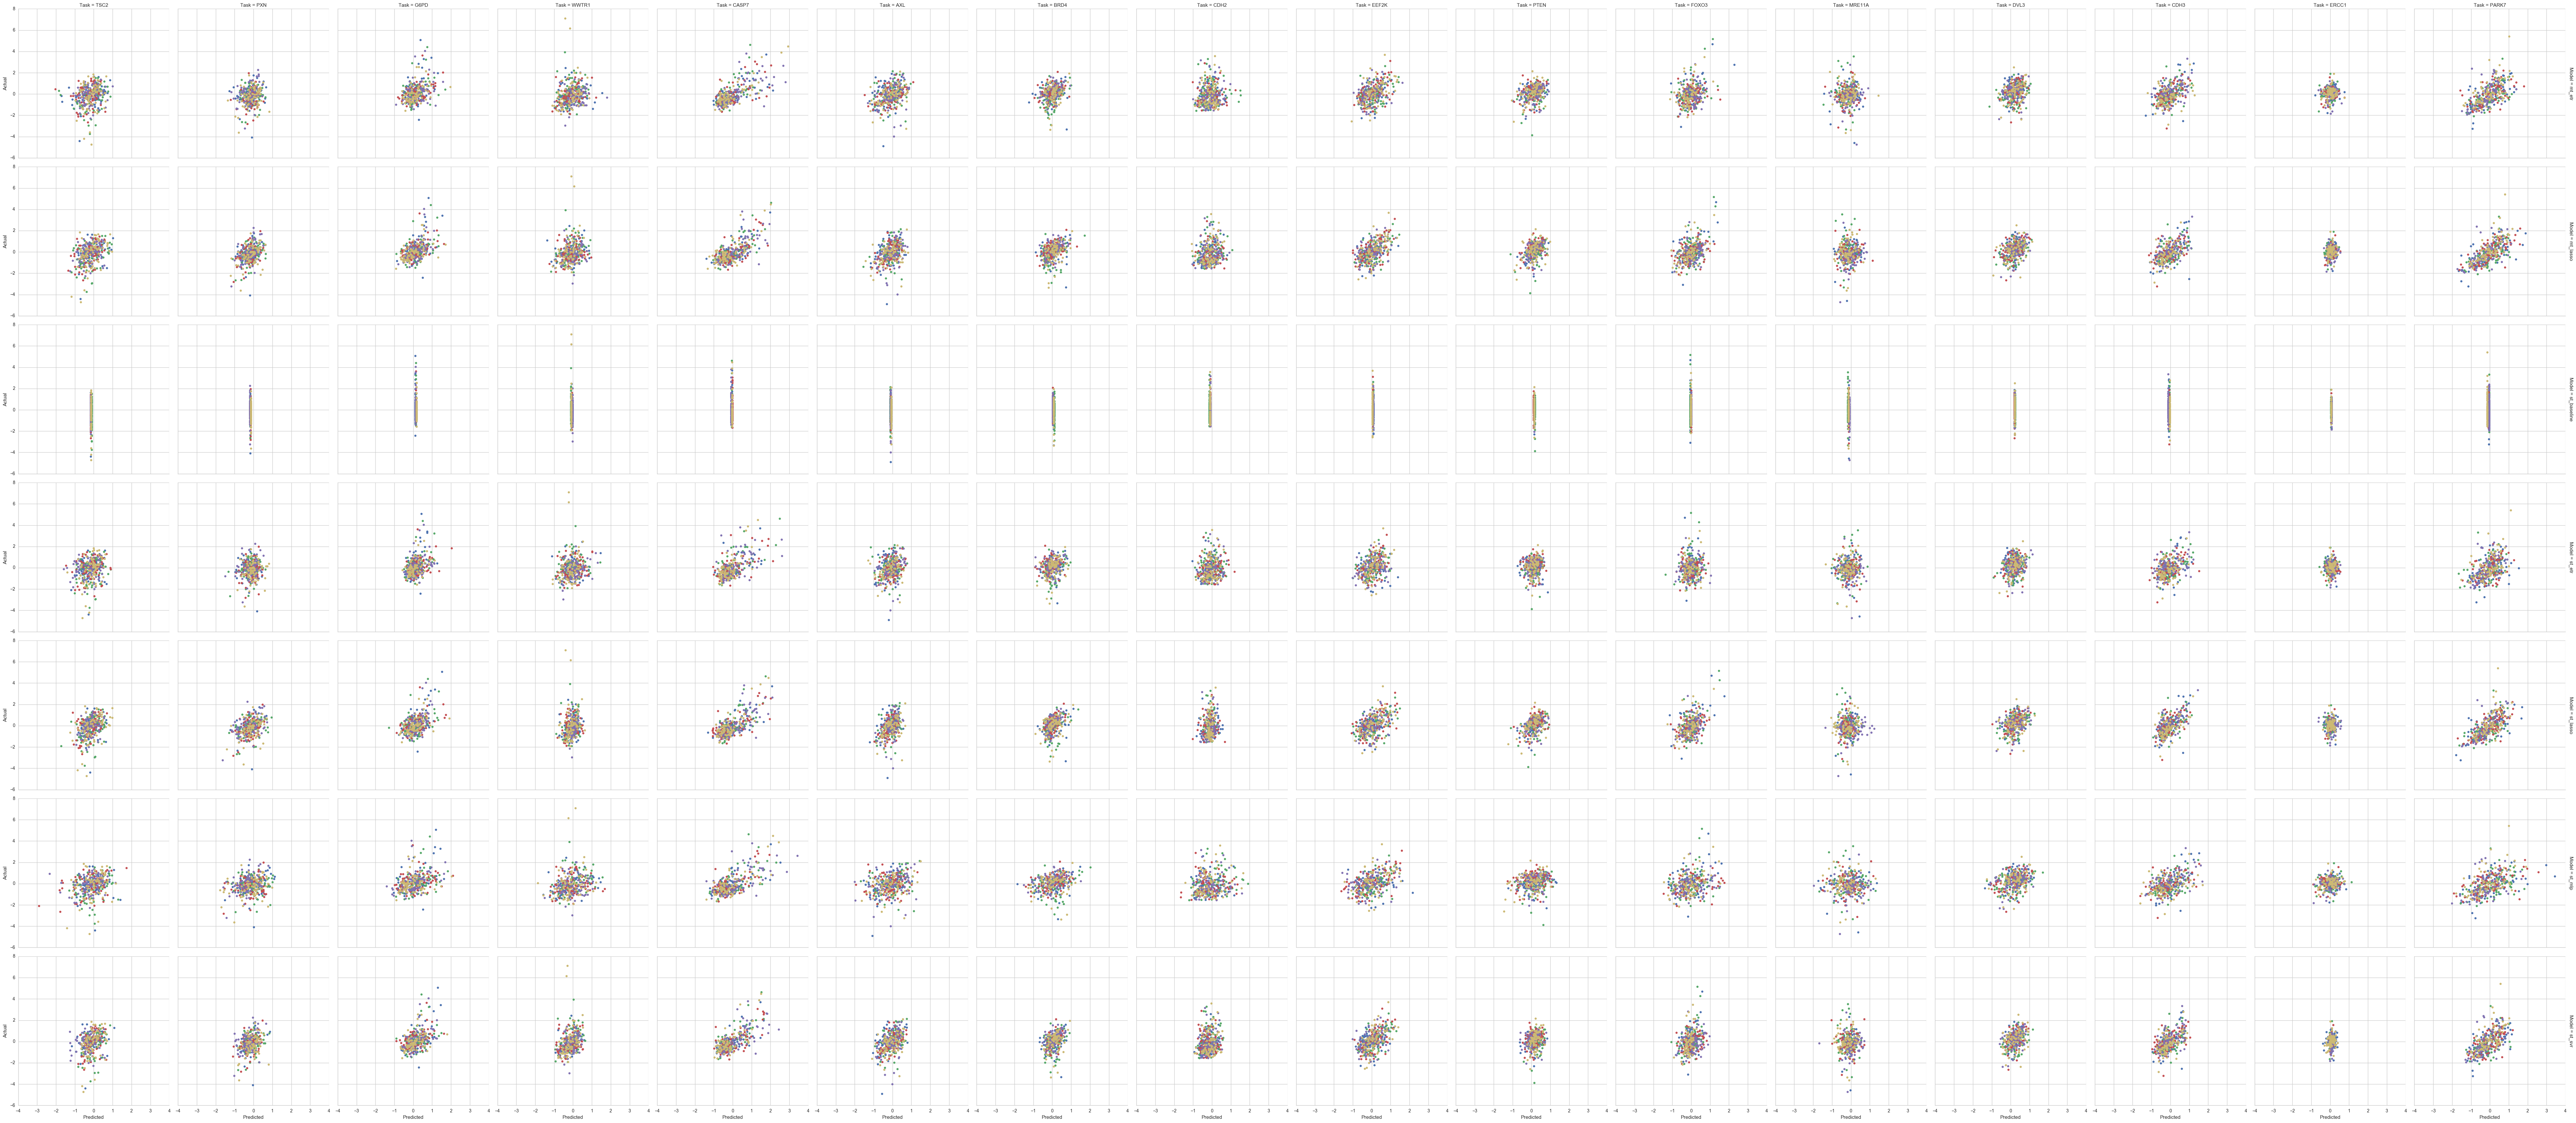

In [106]:
predictions.visualize(
    train_res, predictions.melt(train_res, d_pred), backend='seaborn'
)